# Feature importance of xgboost models
First, we will recreate the xgboost models

### Feel free to skip lower, if you want just the interpretation bits

In [91]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression

#additional libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import cross_validate


# annoying warnings
import warnings
warnings.filterwarnings('ignore')

#additional libraries, Payman
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
import glob
np.random.seed(42)

def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)
        
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)


Xgboost without sampling

In [92]:
xgb_dict = {}
# os.chdir("p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
#     df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'CampaignID'], axis = 1, inplace = True)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test

    xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15)
    

    xgb_fit = xgb_ml.fit(X_train, y_train)
    xgb_preds = xgb_fit.predict(X_val)
#     print(xgb_ml.feature_importances_)
    
    mae = mean_absolute_error(y_val, xgb_preds)
    mse = mean_squared_error(y_val, xgb_preds)
    r_squared = r2_score(y_val, xgb_preds)
    
    xgb_dict[str(file)] = {}
    xgb_dict[str(file)]['mae'] = mae
    xgb_dict[str(file)]['mse'] = mse
    xgb_dict[str(file)]['r_squared'] = r_squared
    xgb_dict[str(file)]['feat_imp'] = xgb_ml.feature_importances_
    
xgb_df = pd.DataFrame.from_dict(xgb_dict)

In [93]:
xgb_df

,no_tempinc.csv,no_tempinc_minmax.csv,no_tempinc_standard.csv,tempinc.csv,tempinc_minmax.csv,tempinc_standard.csv
feat_imp,"[0.012207469, 0.013006349, 0.7322356, 0.010226...","[0.0043219067, 0.0, 0.004733006, 0.9217876, 0....","[0.002517537, 0.0, 0.00288609, 0.88501984, 0.0...","[0.009270809, 0.009607556, 0.78790265, 0.00438...","[0.0038226065, 0.0, 0.002877083, 0.91679627, 0...","[0.0013814281, 0.0, 0.0018894186, 0.9435775, 0..."
mae,0.612694,0.0278662,0.35664,0.70424,0.0290195,0.402176
mse,0.962303,0.001611,0.347604,1.21886,0.0027729,0.512975
r_squared,0.705246,0.720345,0.600739,0.67412,0.621984,0.556111


# Sampling

In [94]:
xgb_s_dict = {}
# os.chdir("./p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
#     df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'CampaignID'], axis = 1, inplace = True)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15)
        
        xgb_fit = xgb_ml.fit(X_train, y_train)
        xgb_preds = xgb_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, xgb_preds)
        mse = mean_squared_error(y_val, xgb_preds)
        r_squared = r2_score(y_val, xgb_preds)
        
        xgb_s_dict[str(file) + '_w' + str(w)] = {}
        xgb_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        xgb_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        xgb_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        xgb_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = xgb_ml.feature_importances_


#         print("MAE: {:.{}f}".format(mae, 2))
#         print("MSE: {:.{}f}".format(mse, 2))
#         print("R-squared: {:.{}f}".format(r_squared, 2))
xgb_s_df = pd.DataFrame.from_dict(xgb_s_dict)
xgb_summ = pd.concat([xgb_df.T, xgb_s_df.T])
xgb_summ['Model'] = 'XGB'

In [95]:
xgb_summ

,feat_imp,mae,mse,r_squared,Model
no_tempinc.csv,"[0.012207469, 0.013006349, 0.7322356, 0.010226...",0.612694,0.962303,0.705246,XGB
no_tempinc_minmax.csv,"[0.0043219067, 0.0, 0.004733006, 0.9217876, 0....",0.0278662,0.001611,0.720345,XGB
no_tempinc_standard.csv,"[0.002517537, 0.0, 0.00288609, 0.88501984, 0.0...",0.35664,0.347604,0.600739,XGB
tempinc.csv,"[0.009270809, 0.009607556, 0.78790265, 0.00438...",0.70424,1.21886,0.67412,XGB
tempinc_minmax.csv,"[0.0038226065, 0.0, 0.002877083, 0.91679627, 0...",0.0290195,0.0027729,0.621984,XGB
tempinc_standard.csv,"[0.0013814281, 0.0, 0.0018894186, 0.9435775, 0...",0.402176,0.512975,0.556111,XGB
no_tempinc.csv_w1,"[0.018961001, 0.012710622, 0.72244096, 0.01029...",0.667499,1.02595,0.661455,XGB
no_tempinc.csv_w3,"[0.0037152858, 0.0028405625, 0.94186664, 0.002...",0.638193,0.8906,0.706118,XGB
no_tempinc.csv_w5,"[0.0035773078, 0.0036005103, 0.94718516, 0.001...",0.645333,0.882803,0.708691,XGB
no_tempinc_minmax.csv_w1,"[0.0032606525, 0.0, 0.004483474, 0.9209425, 0....",0.0299552,0.00379433,0.490006,XGB


Let's focus in on our model with the a good `r2` score, since we have kind of different scales going on for our other variables. We will do `no_tempinc.csv_w3` since this had good performance for Random Forests and for XGboost. So for this, we will use the setup with no scaling, extreme values having 3x normal weighting, and no binary temperature increase variables. Let's do some looks into how this model is making decisions from a global point of view.

In [106]:
df = pd.read_csv("no_tempinc.csv")
df.drop(['CampaignID', 'Unnamed: 0'], axis = 1, inplace = True)

temp_train, val, test = np.split(df.sample(frac=1), 
                            [int(.6*len(df)), 
                             int(.8*len(df))])

y_val = val['Quality']
val.drop(['Quality'], axis = 1, inplace = True)
X_val = val

y_test = test['Quality']
test.drop(['Quality'], axis = 1, inplace = True)
X_test = test

w = 3
#         print('Weight:',w)
temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

y_train = temp_df['Quality']
temp_df.drop(['Quality'], axis = 1, inplace = True)
X_train = temp_df

xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15)

xgb_fit = xgb_ml.fit(X_train, y_train)
xgb_preds = xgb_fit.predict(X_val)

mae = mean_absolute_error(y_val, xgb_preds)
mse = mean_squared_error(y_val, xgb_preds)
r_squared = r2_score(y_val, xgb_preds)

xgb_s_dict[str(file) + '_w' + str(w)] = {}
xgb_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
xgb_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
xgb_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
xgb_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = xgb_ml.feature_importances_

In [107]:
def get_importance_graph(model, parameter):
    # ['weight', 'gain', 'cover']
    imps = model.get_booster().get_score(importance_type= parameter)
    keys = []
    values = []
    for key in imps.keys():
        keys.append(key)
        values.append(imps[key])
        
    imp_df = pd.DataFrame({"Feature" : keys, "Importance" : values}).sort_values('Importance',ascending=True)
    title_str = 'XGBoost ' + parameter + ' importance'
    imp_df.plot.barh(x='Feature', y='Importance', figsize=(8,8),legend=False, title=title_str)

### If you were skipping, stop skipping here

There's a bunch of different ways you can measure variable importance for an XGBoost model (source: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

Going through them, we have:
* __Weight__: Number of times the variable appears as a decision variable in the tree
* __Gain__: How much an individual variable reduces errors in splits made on this variable in trees
* __Cover__: How many observations are put into a leaf node based on a decision on this variable


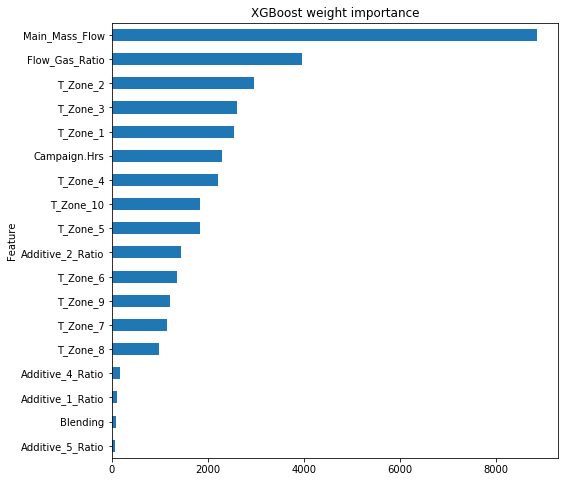

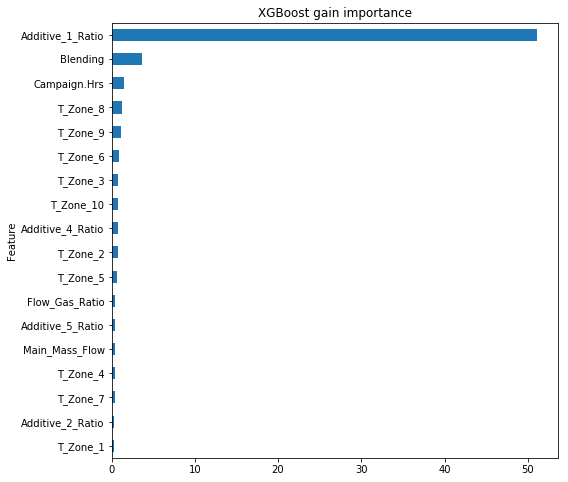

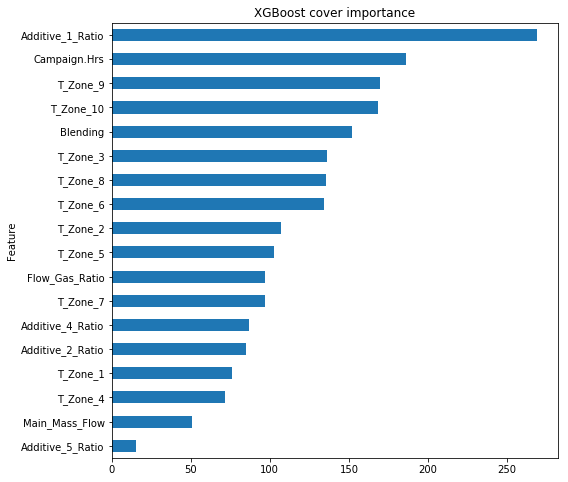

In [108]:
for par in ['weight', 'gain', 'cover']: 
    get_importance_graph(xgb_ml, par)

So we see that we should expect Additive 1 to be a decision variable very upstream in our model, since it has high coverage and high gain. In terms of weight, it is also logical that we see the main mass flow as the highest there, since there were a wide range of values here (and importantly for a tree-based algorithm, a lot of unique values). 

Looking at these metrics, it can be confusing in terms of what is actually significant. It's not surprising that high gain variables are also low weight, since the overall information gain made by a large split doesn't need to be made over the course of many decisions. One variable that has two possible values might have a high gain and coverage because it has an easy spot to split that has a lot of information gain, but a variable that has a lot of possibly split points may have a more difficult time finding a high information gain split point. Therefore, variables like this may be important, but the importance gets distributed to many smaller decision points rather than one big one. So we should take these graphs with a grain of salt.

Another way to interpret the variable importance is to look at the permutation variable importance- that is, if we shuffle up all the values in one column, how much worse does the fit get? This method is model-agnostic and gets around a lot of the issues we had with our other methods. The one catch, which exists in some forms with our other methods as well, is that we only look at one variable at a time. So highly correlated variables may have effects mixed up.

In [111]:
def mae(rf, X_val, y_val):
    return mean_absolute_error(y_val, rf.predict(X_val))

def r2(rf, X_val, y_val):
    return r2_score(y_val, rf.predict(X_val))

,Importance
Feature,
Main_Mass_Flow,0.307055
Additive_1_Ratio,0.282697
Additive_2_Ratio,0.054295
Additive_3_Ratio,0.000000
Additive_4_Ratio,0.009338
Additive_5_Ratio,-0.000077
Additive_6_Ratio,0.000000
Flow_Gas_Ratio,0.140506
T_Zone_1,0.042346


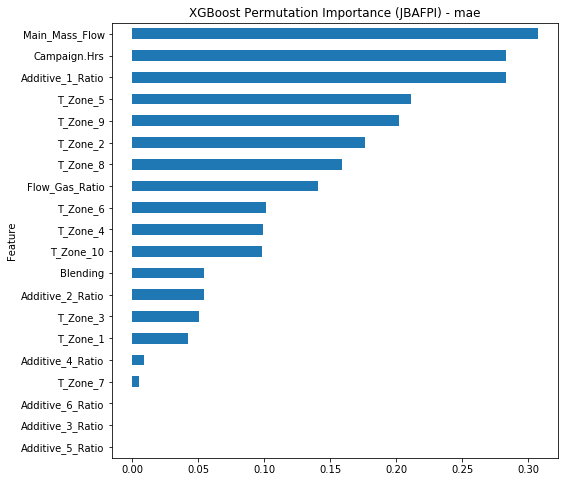

In [112]:
def JBAFPI(rf, x_data, y_data, metric):
    baseline = metric(rf,x_data,y_data)
    Importance = []
    feature = []
    for col in x_data.columns:
        save = x_data[col].copy()
        x_data[col] = np.random.permutation(x_data[col])
        m = metric(rf,x_data,y_data)
        x_data[col] = save
        Importance.append((m-baseline))
        feature.append(col)
    return pd.DataFrame({'Importance':Importance,'Feature':feature}).set_index("Feature")

perm_imp_JBAFPI = JBAFPI(xgb_ml, X_val, y_val, mae)
display(perm_imp_JBAFPI)
perm_imp_JBAFPI = perm_imp_JBAFPI.sort_values('Importance',ascending=True)
perm_imp_JBAFPI.plot.barh(figsize=(8,8),legend=False, title="XGBoost Permutation Importance (JBAFPI) - mae")

This tends to line up pretty nicely, though not exactly, to our gain importance graph. The relative weights here are very different compared to gain, because inherently gain is going to be biased towards the more upstream splitting variables. Here, we can treat them a bit more independently.

With all of these graphs, if I were an engineer at this plant I would say that in order to make changes in quality, I should consider changing my main flow, Additive 1, and a few of the different temperatures in the heater.

It's important to note where this problem starts to get a little bit more interesting- some of the variables, such as campaign hours, may not really be under our control even though we consider them to be important for predicting. Figuring out ways to control the process for a desired outcome in the presence of many things you can't control is what makes these problems difficult. A simulation-based approach or stochastic optimization methods with a lot of constraints are typically used here, but that's out of the scope for our current assignment.